<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Side_Objective_IPI_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Side Objective: IPI calculation to investigate whether female rapping is species specific
###(Making use of code from Frog_calling_separation_pipline.ipynb and Wave Envelope.ipynb)


In [1]:
!pip install librosa
import os
import librosa
import time
import seaborn as sns
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import random
from scipy import fftpack, signal
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [2]:
def clear_out(lower,upper,data,points_per_freq):
  target_idx_noise_lower = int(points_per_freq * lower)
  target_idx_noise_upper = int(points_per_freq * upper)
  data[: target_idx_noise_lower] = 0
  data[target_idx_noise_upper:] = 0
  
def fourier_transform(samples, sampling_rate):
  #fourier transform on audio file
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  return xf,yf

#smooth the curve
def smooth_curve(randomlist_yf,sigma=40):
  #We get a smoother curve upon increasing the value of sigma.
  y_smoothed = gaussian_filter1d(randomlist_yf, sigma)
  peaks, _  = scipy.signal.find_peaks(y_smoothed)
  troughs, _  = scipy.signal.find_peaks(-y_smoothed)
  return peaks,troughs,y_smoothed

def peak_processing(peaks,randomlist_xf):
  #remove all peaks with xf value below 450, between 700 and 1600, and above 2500
  for i in peaks:
    if((randomlist_xf[i]<450) or
      #((randomlist_xf[i]>700) and (randomlist_xf[i]<1600))or
      (randomlist_xf[i]>2500)):
      peaks = np.delete(peaks,np.argwhere(peaks == i))
  peaks_list = randomlist_xf[peaks]
  return peaks_list

def trough_processing(troughs,randomlist_xf):
  #if the smallest trough that's below 450 is below 350  replace it with 350
  if(randomlist_xf[troughs].min()<350):
    troughs_list = np.where(randomlist_xf[troughs]<350,350,randomlist_xf[troughs])
  else:
    troughs_list = np.append([350], randomlist_xf[troughs], axis = 0)
  return troughs_list

def generate_boundaries(peaks_list,troughs_list):
  #getting the boundaries for the female call
  i = 0
  while(troughs_list[i] < peaks_list[0]):
    i+=1
  upper_bound_0 = troughs_list[i]
  lower_bound_0 = troughs_list[i-1]

  #getting the boundaries for the male call
  while(troughs_list[i] < peaks_list[1]):
    i+=1
  upper_bound_1 = troughs_list[i]
  #the lower bound of the male call: take the 
  #difference between the upper bound and the peak,
  #and use the peak value to subtract the difference
  difference = upper_bound_1 - peaks_list[1]
  lower_bound_1 = peaks_list[1] - difference
  #the lower bound of male call can't go below 1500Hz for
  #Xenopus Laevis or Xenopus Petersii
  if(lower_bound_1 < 1500):
    lower_bound_1 = 1500
  boundary_list = [150,lower_bound_0,upper_bound_0,lower_bound_1,3000]
  return boundary_list

def write_audio(samples,lowerlimit,upperlimit,points_per_freq,file_name,specific_name,sampling_rate=44100):
  yf_special = rfft(samples)
  clear_out(lowerlimit,upperlimit,yf_special,points_per_freq)
  new_sig = irfft(yf_special)
  write(file_name+specific_name,sampling_rate,new_sig)

###Female-male Separation Pipeline

In [3]:
def separation_for_IPI_calculating(file_path,sampling_rate=44100):
  file_name = os.path.basename(file_path)
  #load audio file
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  #perform fourier transform on the data
  xf,yf = fourier_transform(samples, sampling_rate)

  #get the number of points per frequency
  points_per_freq = len(xf) / (sampling_rate / 2)

  #rough clean of data for smoothing
  clear_out(150,3000,yf,points_per_freq)

  #sample down audio file to 23274 data points
  randomlist = random.sample(list(range(0,(len(xf)-1))),23274)
  randomlist.sort()
  randomlist_xf = xf[randomlist]
  randomlist_yf = np.abs(yf)[randomlist]

  peaks,troughs,y_smoothed = smooth_curve(randomlist_yf)

  #data processing on the peaks and troughs
  peaks_list = peak_processing(peaks,randomlist_xf)
  troughs_list = trough_processing(troughs,randomlist_xf)

  boundary_list = generate_boundaries(peaks_list,troughs_list)

  #plot the graph
  
  plt.figure(figsize=(20,5))
  plt.plot(xf,np.abs(yf),color="grey")
  plt.plot(randomlist_xf,y_smoothed,color="red")
  plt.plot(randomlist_xf[peaks],y_smoothed[peaks],"x")
  plt.plot(randomlist_xf[troughs],y_smoothed[troughs],"o",color="green")
  plt.vlines(boundary_list,-10,3000,colors='black', linestyles='dashed')
  ticks = np.concatenate([np.arange(0, 4000, step=1000),boundary_list])
  ticks.sort()
  plt.xticks(ticks)
  plt.xlim((0,4000))
  plt.show()

  #obtain female signal
  yf_special = rfft(samples)
  clear_out(boundary_list[1],boundary_list[2],yf_special,points_per_freq)
  female = irfft(yf_special)

  #obtain noise signal
  yf_special = rfft(samples)
  clear_out(boundary_list[0],350,yf_special,points_per_freq)
  noise = irfft(yf_special)

  print('female lower bound: ',boundary_list[1])
  print('female higher bound: ',boundary_list[2])
  return female, noise

#####Testing out the separation pipeline on petersii

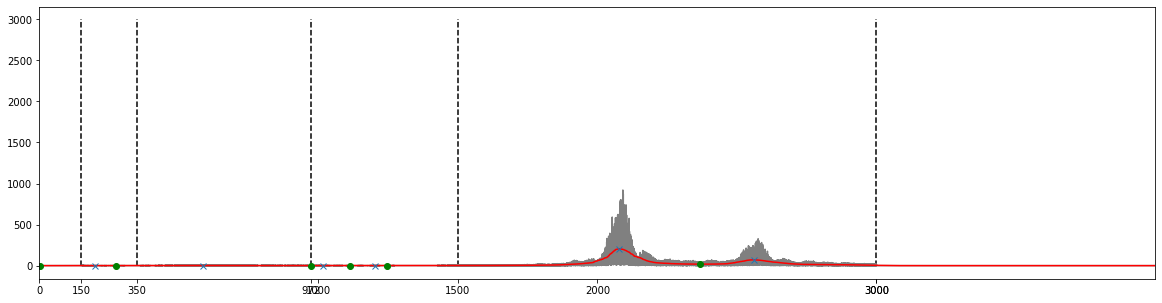

female lower bound:  350.0
female higher bound:  972.0907766750074


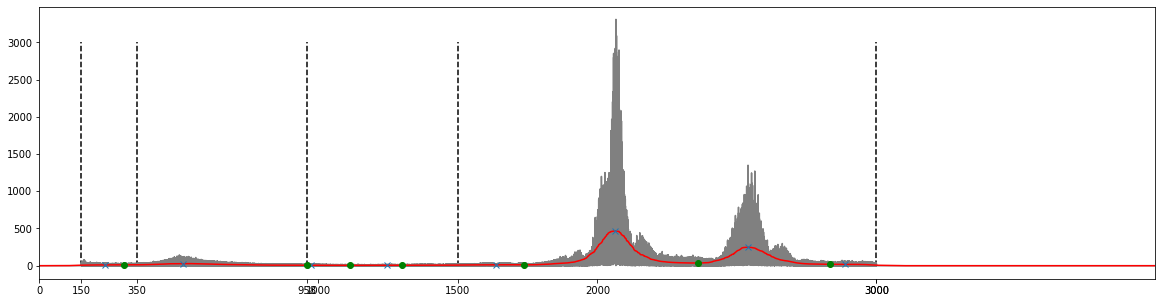

female lower bound:  350.0
female higher bound:  957.5334499142366


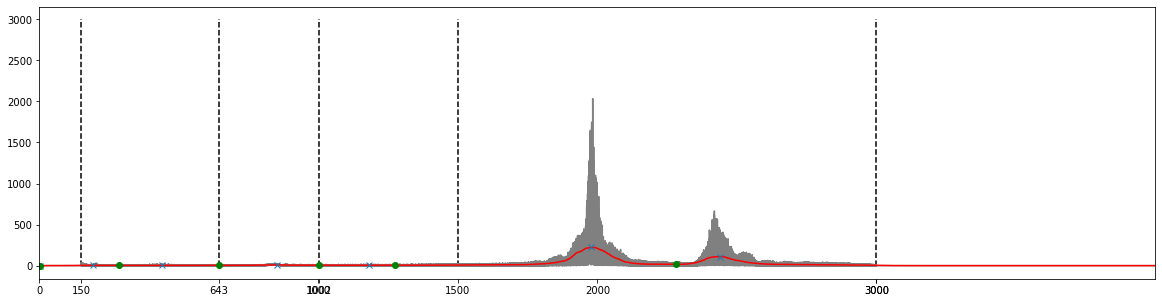

female lower bound:  643.1260422871726
female higher bound:  1002.2797483428018


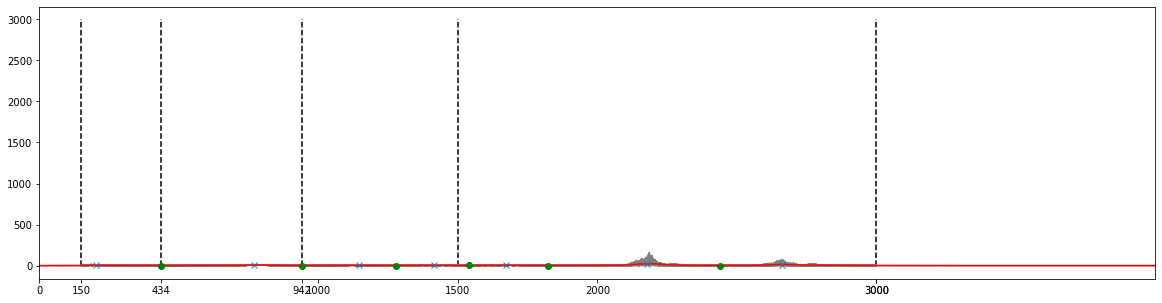

female lower bound:  434.44325421587297
female higher bound:  941.751614974789


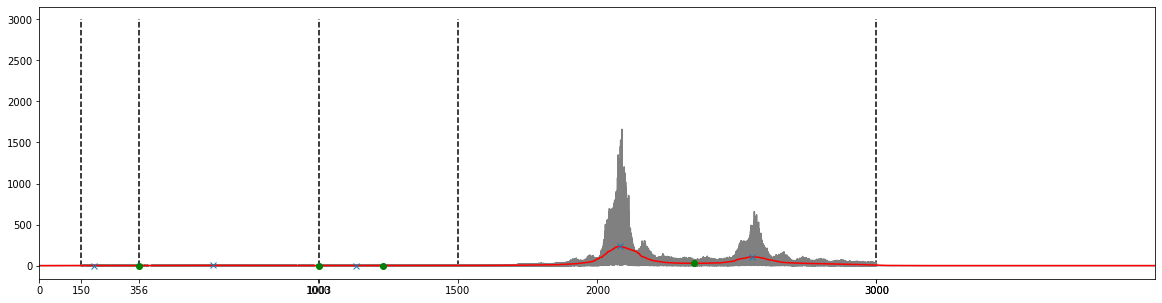

female lower bound:  356.0259572970095
female higher bound:  1002.8317762965821


(array([-0.00038779, -0.00046784, -0.00054089, ..., -0.00015733,
        -0.00022763, -0.00030599], dtype=float32),
 array([-0.00038779, -0.00046784, -0.00054089, ..., -0.00015733,
        -0.00022763, -0.00030599], dtype=float32))

In [4]:
#testing out the separation pipeline on petersii
separation_for_IPI_calculating('/content/Petersii_02-F8212-F821A-220714_1916_1_min.wav')
separation_for_IPI_calculating('/content/Petersii_01-F8244-F8259-220701_0019_8_min.wav')
separation_for_IPI_calculating('/content/Petersii_02-F820D-F8239-220630_2215_6_min.wav')
separation_for_IPI_calculating('/content/Petersii_02-F8218-F8215-220623_2203_2_min.wav')
separation_for_IPI_calculating('/content/Petersii_02-F8212-F829D-220617_0040_4_min.wav')

#####Testing out the separation pipeline on vic

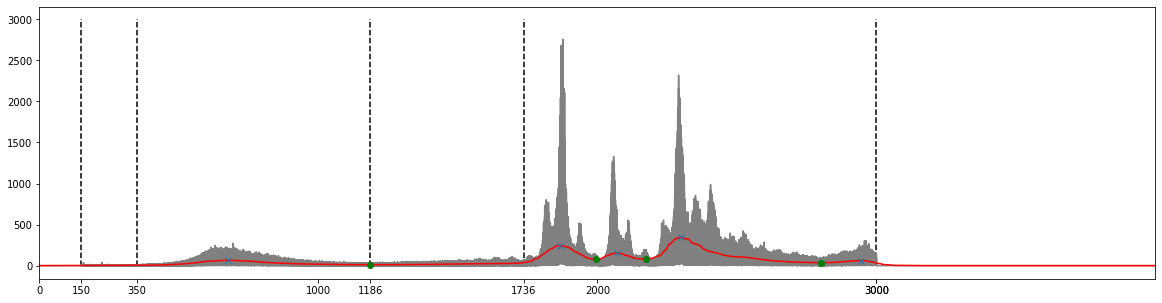

female lower bound:  350.0
female higher bound:  1186.0135933854463


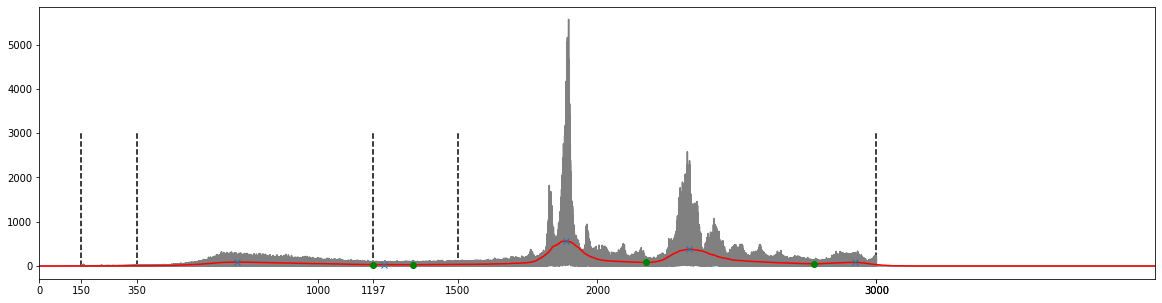

female lower bound:  350.0
female higher bound:  1197.0107417244776


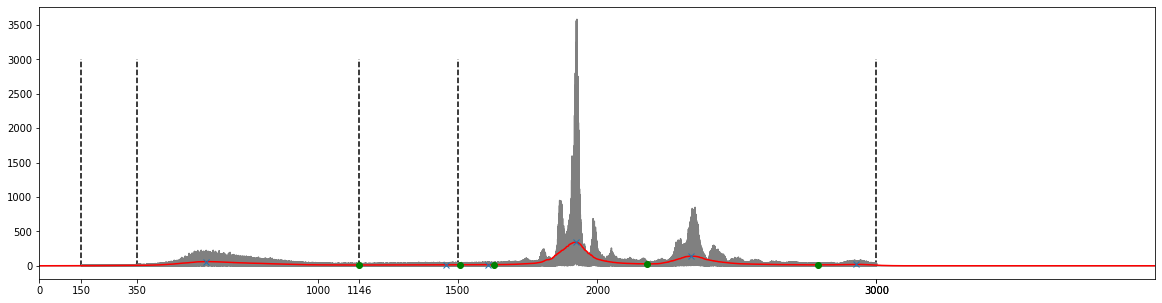

female lower bound:  350.0
female higher bound:  1145.7659542627123


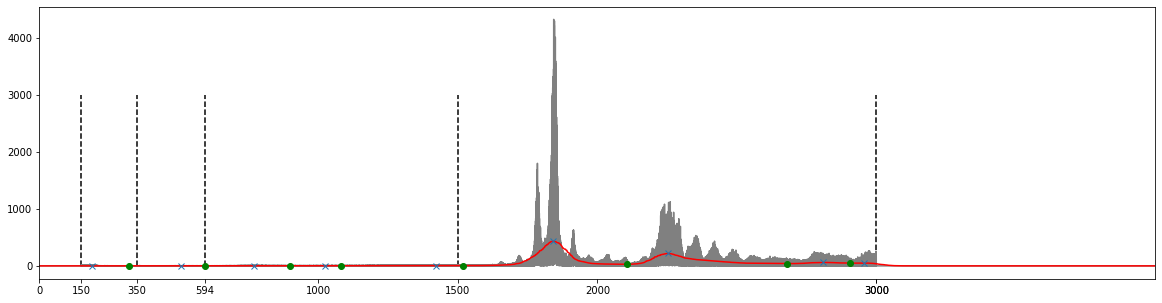

female lower bound:  350.0
female higher bound:  594.038748795376


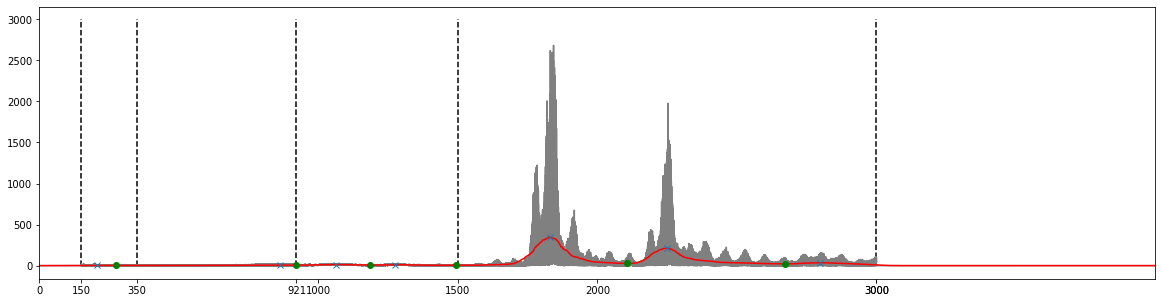

female lower bound:  350.0
female higher bound:  921.1323124068605


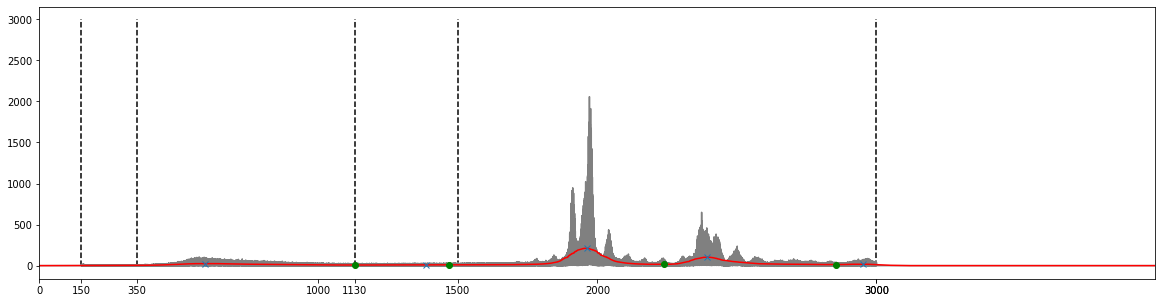

female lower bound:  350.0
female higher bound:  1130.2826806702792


(array([-9.7437020e-05, -2.3806057e-04, -3.6543081e-04, ...,
         3.1178136e-04,  1.8671392e-04,  4.7333440e-05], dtype=float32),
 array([-9.7437020e-05, -2.3806057e-04, -3.6543081e-04, ...,
         3.1178136e-04,  1.8671392e-04,  4.7333440e-05], dtype=float32))

In [5]:
#testing out the separation pipeline on vic
separation_for_IPI_calculating('/content/Vic_01-AD815-AD7EE-220629_0025_8_min.wav')
separation_for_IPI_calculating('/content/Vic_01-AD81A-AD7E7-220630_0036_8_min.wav')
separation_for_IPI_calculating('/content/Vic_02-AD7D0-AD7DE-220629_0025_8_min.wav')
separation_for_IPI_calculating('/content/Vic_02-AD7D9-AD78D-220629_2231_8_min.wav')
separation_for_IPI_calculating('/content/Vic_02-AD800-AD824-220627_2204_8_min.wav')
separation_for_IPI_calculating('/content/Vic_03-AD7CA-AD81C-220629_0025_8_min.wav')

#####Testing out the separation pipeline on laevis

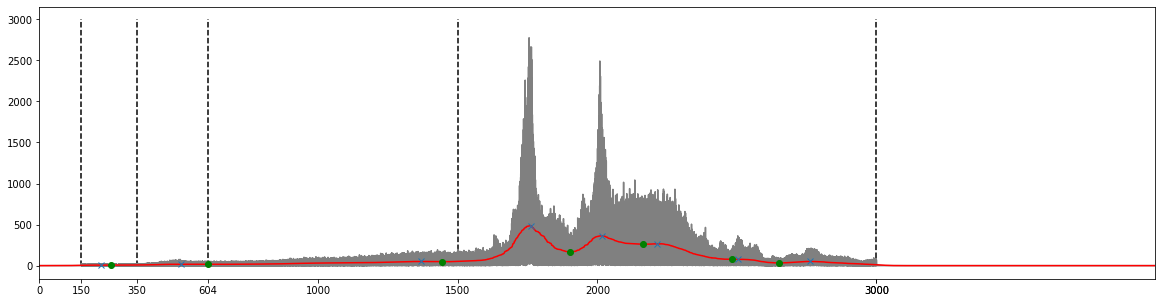

female lower bound:  350.0
female higher bound:  603.8822944527437


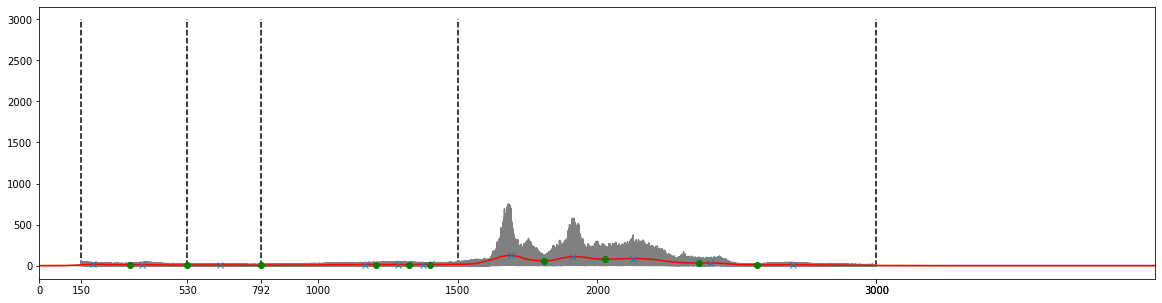

female lower bound:  529.7236175012918
female higher bound:  792.4505811110179


(array([ 4.5681059e-05,  8.8551838e-05,  1.2704704e-04, ...,
        -7.9011035e-05, -4.1166517e-05,  1.3942739e-06], dtype=float32),
 array([ 4.5681059e-05,  8.8551838e-05,  1.2704704e-04, ...,
        -7.9011035e-05, -4.1166517e-05,  1.3942739e-06], dtype=float32))

In [4]:
#testing out the separation pipeline on laevis
separation_for_IPI_calculating('/content/Laevis_01-F818D-F8387-220616_0456_8min_selection.wav')
separation_for_IPI_calculating('/content/Laevis_02-F832F-F837D-220616_0456.wav')

#####Testing out the separation pipeline on poweri

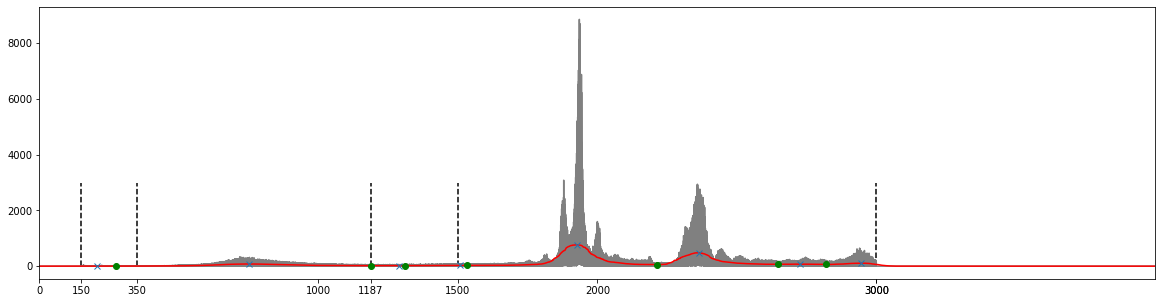

female lower bound:  350.0
female higher bound:  1187.0261494300537


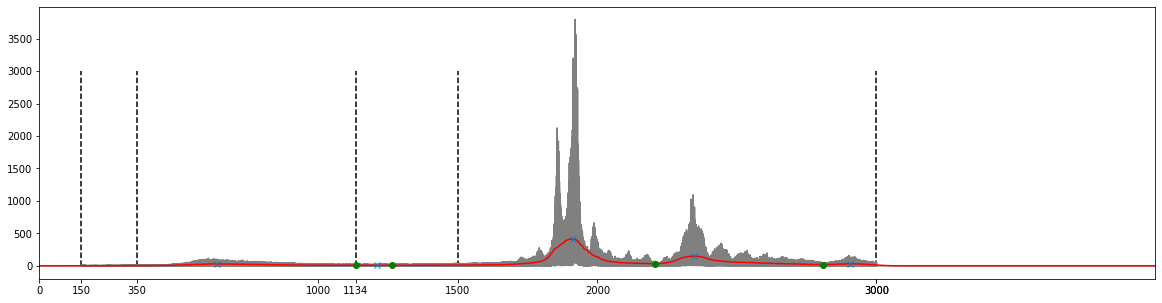

female lower bound:  350.0
female higher bound:  1134.2342780145243


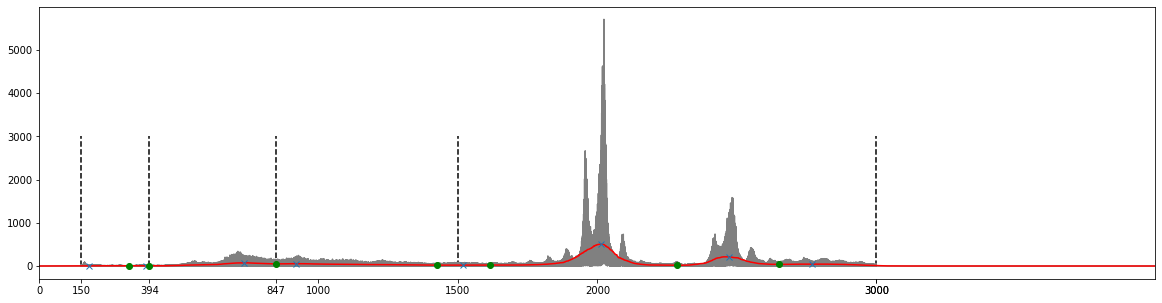

female lower bound:  394.45882062578886
female higher bound:  846.5712600873322


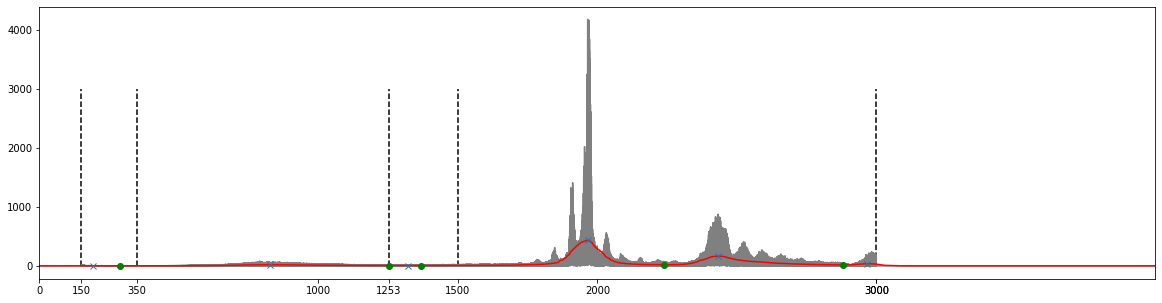

female lower bound:  350.0
female higher bound:  1253.4346042193547


(array([ 5.9201255e-05, -9.3821436e-06, -7.1455528e-05, ...,
         2.6356359e-04,  1.9998490e-04,  1.3042599e-04], dtype=float32),
 array([ 5.9201255e-05, -9.3821436e-06, -7.1455528e-05, ...,
         2.6356359e-04,  1.9998490e-04,  1.3042599e-04], dtype=float32))

In [5]:
#testing out the separation pipeline on poweri
separation_for_IPI_calculating('/content/Poweri_01-AD807-AD7EF-220708_0016_8_min.wav')
separation_for_IPI_calculating('/content/Poweri_02-AD812-AD810-220713_1913_8_min.wav')
separation_for_IPI_calculating('/content/Poweri_02-AD826-AD80A-220712_0006_8_min.wav')
separation_for_IPI_calculating('/content/Powerii_03-AD82A-AD7CD-220711_2202_8_min.wav')

###Wave Envelope and Find Peaks

In [4]:
#get statistics on rapping IPI
def get_rapping_IPI_stats(peak_indices_list,x_time):
  IPI = []
  for i in range(0,len(peak_indices_list)-1):
    front = peak_indices_list[i]
    back = peak_indices_list[i+1]
    difference = x_time[back] - x_time[front]
    IPI.append(difference)
  #Assumption: Rapping is categorized by 3 or more consecutive pulses within 1 second.
  i=0
  IPI_processed = []
  while (i < (len(IPI)-2)):
  #while(0):
    if((IPI[i]+IPI[i+1])<1):
      IPI_processed.append(IPI[i])
      IPI_processed.append(IPI[i+1])
      k = 2
      while(1):
        if((IPI[i+k]<0.5)and(i+k <(len(IPI)-1))):
          IPI_processed.append(IPI[i+k])
          k=k+1
        else:
          i = i+k+1
          break
    else:
      i=i+1
  #generate statistics for rapping IPI plot
  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)

  IPI_processed = [i for i in IPI_processed if (i<median+2*std)]

  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)

  plt.figure(figsize=(20,5))
  sns.displot(IPI_processed)
  plt.axvline(mean,color="grey",label="mean",linestyle='--')
  plt.axvline(median,color="black",label="median",linestyle='--')
  plt.legend()
  plt.show()
  return IPI_processed, mean, median, std

def noise_filter(noise,signal,sigma=100,sampling_rate=44100,peak_height=0.001):
  #get noise peaks
  noise_smoothed = gaussian_filter1d(abs(noise),sigma)
  noise_peaks, _ = scipy.signal.find_peaks(noise_smoothed,height=peak_height)
  #filtering
  for i in noise_peaks:
    signal[int(i-(sigma*10/2)):int(i+(sigma*10/2))]=0
  return signal

In [10]:
def IPI_calculation(file_path):
  female, noise = separation_for_IPI_calculating(file_path)
  hilbert_signal = abs(signal.hilbert(female))
  #time vector
  sampling_rate = 44100
  duration = len(hilbert_signal)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)
  threshold = 0.05*np.max(hilbert_signal)
  peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.025*44100)
  plt.figure(figsize=(20,5))
  plt.plot(x_time, hilbert_signal)
  plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
  #plt.xlim(40*44100, 41*44100)
  plt.show()

  IPI_processed,mean,median,std = get_rapping_IPI_stats(peaks,x_time)
  print("Mean: ", mean,"; Median: ",median, "; STD: ", std)

#####Calculating IPI for laevis

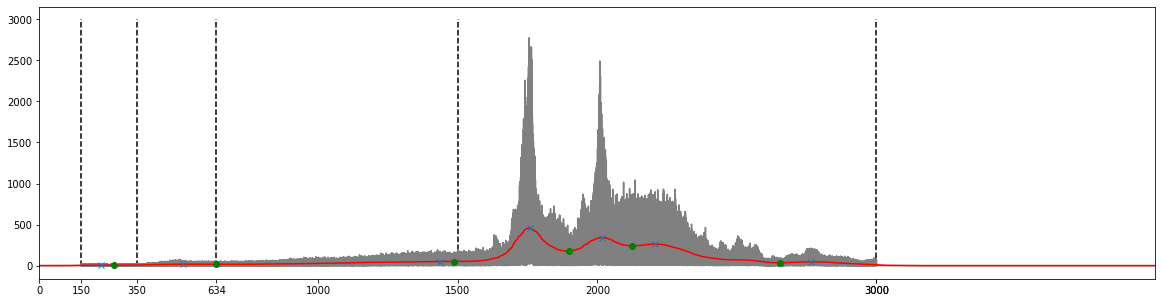

female lower bound:  350.0
female higher bound:  633.7969305320005


In [11]:
#the first laevis
female, noise = separation_for_IPI_calculating('/content/Laevis_01-F818D-F8387-220616_0456_8min_selection.wav')

In [13]:
hilbert_signal = abs(signal.hilbert(female))

In [14]:
#time vector
sampling_rate = 44100
duration = len(hilbert_signal)/sampling_rate
x_time = np.arange(0,duration,1/sampling_rate)

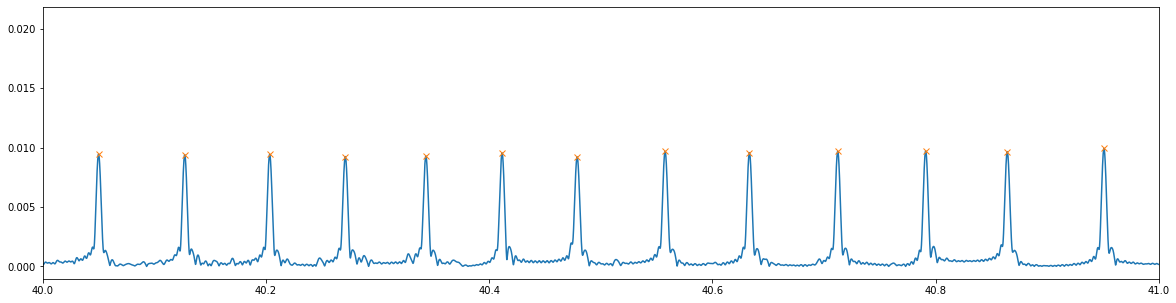

In [15]:
threshold = 0.05*np.max(hilbert_signal)
peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.025*44100)

plt.figure(figsize=(20,5))
plt.plot(x_time, hilbert_signal)
plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
plt.xlim(40, 41)
plt.show()

<Figure size 1440x360 with 0 Axes>

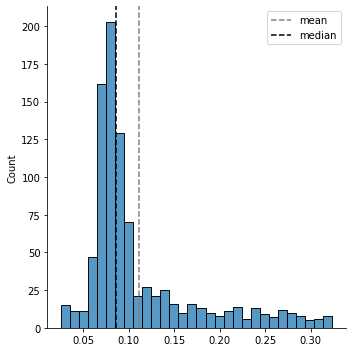

Mean:  0.1113227022410696 ; Median:  0.08556689342401569 ; STD:  0.0629055638016477


In [16]:
IPI_processed,mean,median,std = get_rapping_IPI_stats(peaks,x_time)
print("Mean: ", mean,"; Median: ",median, "; STD: ", std)

In [ ]:
#the second laevis
IPI_calculation('/content/Laevis_02-F832F-F837D-220616_0456.wav')

#####Calculation IPI for petersii

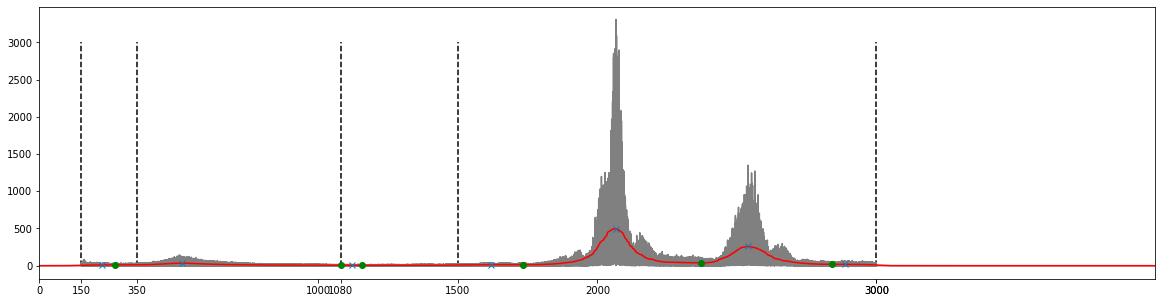

female lower bound:  350.0
female higher bound:  1079.8488866234718


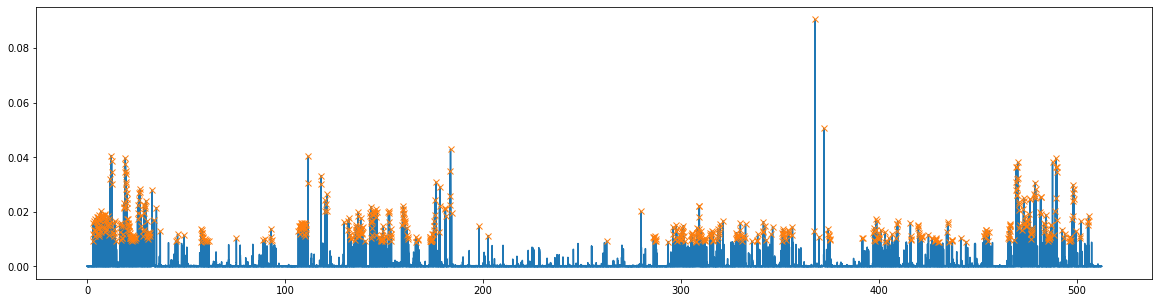

<Figure size 1440x360 with 0 Axes>

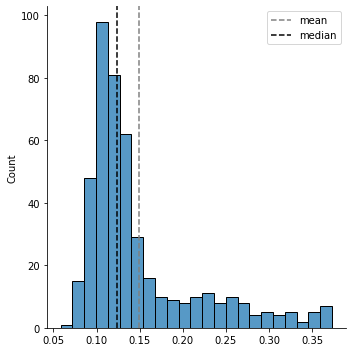

Mean:  0.1489575625571865 ; Median:  0.12382086167799855 ; STD:  0.06660674016463075


In [8]:
IPI_calculation('/content/Petersii_01-F8244-F8259-220701_0019_8_min.wav')